In [32]:
# استيراد المكتبات اللازمة للعمل مع البيانات وتحليلها

import pandas as pd  # مكتبة لتحليل البيانات ومعالجتها بسهولة
import matplotlib.pyplot as plt  # مكتبة لرسم المخططات البيانية
import mysql.connector  # مكتبة للتعامل مع قواعد بيانات MySQL

In [33]:
def make_connection_with_db():
  
    # إنشاء الاتصال بقاعدة البيانات
    connection_mydb = mysql.connector.connect(
        host="localhost",   # اسم المضيف (السيرفر)
        user="root",        # اسم المستخدم لقاعدة البيانات
        password="",        # كلمة المرور (فارغة هنا)
        database="wp-ecommerce"  # اسم قاعدة البيانات
    )

    # إنشاء مؤشر للتعامل مع قاعدة البيانات
    cursor = connection_mydb.cursor(dictionary=True)  # استخدام dictionary=True لإرجاع النتائج كمصفوفات قاموسية
    
    return connection_mydb, cursor  # إرجاع الاتصال والمؤشر

In [34]:
def get_categories_sales():
    #  جلب بيانات مبيعات الفئات (Categories Sales) من قاعدة البيانات.

    # إنشاء اتصال بقاعدة البيانات
    _, cursor = make_connection_with_db()

    # استعلام SQL لجلب بيانات المبيعات لكل فئة من الفئات
    sql = '''SELECT wp_term_taxonomy.term_id , wp_terms.name ,   
            sum(wp_wc_order_product_lookup.product_qty) as sumsales
            FROM wp_wc_order_product_lookup 
            INNER JOIN wp_term_relationships  ON wp_term_relationships.object_id = wp_wc_order_product_lookup.product_id
            INNER JOIN wp_term_taxonomy ON wp_term_relationships.term_taxonomy_id = wp_term_taxonomy.term_taxonomy_id
            INNER JOIN wp_terms ON wp_terms.term_id = wp_term_taxonomy.term_id
            WHERE wp_term_taxonomy.taxonomy ='product_cat' 
            GROUP BY wp_term_taxonomy.term_id'''

    # تنفيذ الاستعلام
    cursor.execute(sql)

    # جلب جميع النتائج
    results = cursor.fetchall()

    # إنشاء DataFrame لتخزين البيانات المسترجعة
    df = pd.DataFrame(columns=['category_id', 'Category', 'Sales'])

    # معالجة البيانات وإضافتها إلى DataFrame
    for row in results:
        category_id = row['term_id']
        Category = row['name']
        Sales = row['sumsales']

        obj = {
            "category_id": [category_id],
            "Category": [Category],
            "Sales": [Sales]
        }

        df_obj = pd.DataFrame(obj)

        # دمج البيانات المسترجعة مع DataFrame الأساسي
        df = pd.concat([df, df_obj], ignore_index=True)

    return df

In [35]:
df = get_categories_sales()
df

,category_id,Category,Sales
0,74,ملابس رجالي,2044
1,82,إكسسوارات,506
2,76,أحذية رجالي,1283
3,75,ملابس نسائي,2248
4,77,أحذية نسائي,758
5,78,إلكترونيات,1392
6,79,مستحضرات تجميل,905


In [40]:
def show_customers_by_countries_bars():
    
    # جلب بيانات المبيعات للفئات المختلفة من قاعدة البيانات
    df = get_categories_sales()

    import numpy as np
    import arabic_reshaper  # استيراد مكتبة لإعادة تشكيل النصوص العربية
    from bidi.algorithm import get_display  # استيراد مكتبة لضبط اتجاه النصوص العربية
    
    # معالجة النصوص العربية لتظهر بالشكل الصحيح في المخططات
    df['Category'] = df['Category'].apply(lambda a: get_display(arabic_reshaper.reshape(a)))
    
    # استخراج أسماء الفئات (التصنيفات) وعدد المبيعات لكل فئة
    x = df['Category']
    y = df['Sales']
    
    # تحديد حجم المخطط البياني
    plt.figure(figsize=(12,6))
    
    # تسمية المحور الأفقي كـ "الفئات"
    plt.xlabel("Category")
    
    # تسمية المحور العمودي كـ "المبيعات"
    plt.ylabel("Sales")
    
    # وضع عنوان رئيسي للمخطط
    plt.title('Sales per Categories')
    
    # قائمة لتخزين الألوان العشوائية لكل شريط في المخطط
    colors = []
    
    for i in range(len(x)):
        
        # إنشاء لون عشوائي لكل فئة من الفئات
        colors.append([np.random.rand(), np.random.rand(), np.random.rand()])
        
        # إضافة عدد المبيعات أعلى كل شريط
        plt.text(x=i, y=y[i], s=y[i])
    
    # رسم المخطط الشريطي باستخدام الألوان العشوائية
    plt.bar(x, y, color=colors)
    
    # عرض المخطط النهائي
    plt.show()

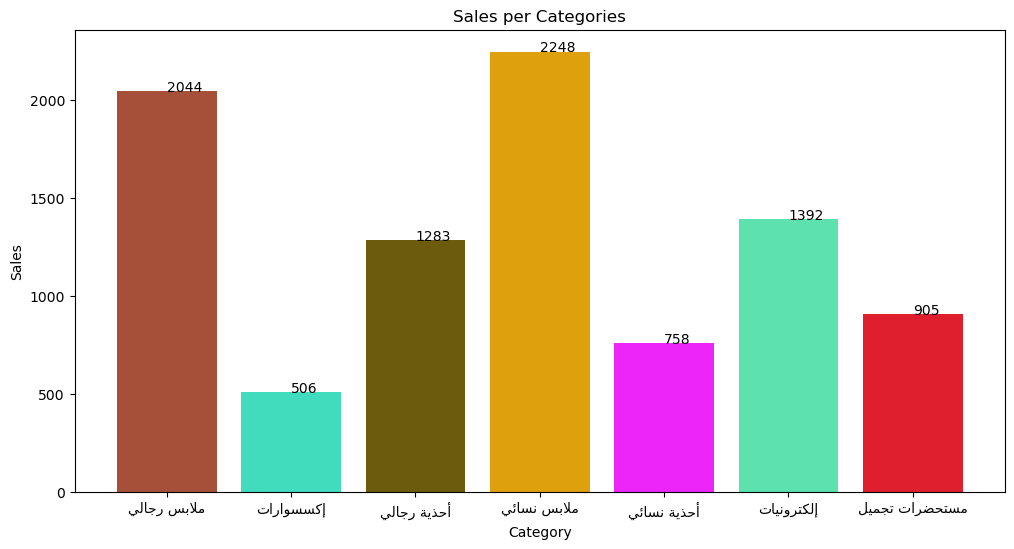

In [41]:
show_customers_by_countries_bars()

In [29]:
def show_categories_sales_pie():
    
    # جلب بيانات المبيعات للفئات المختلفة من قاعدة البيانات
    df = get_categories_sales()
    
    import arabic_reshaper  # استيراد مكتبة لإعادة تشكيل النصوص العربية
    from bidi.algorithm import get_display  # استيراد مكتبة لضبط اتجاه النصوص العربية
    
    # معالجة النصوص العربية لتظهر بالشكل الصحيح في المخططات
    df['Category'] = df['Category'].apply(lambda a: get_display(arabic_reshaper.reshape(a)))
    
    # تحديد حجم المخطط الدائري
    plt.figure(figsize=(10,6))
    
    # رسم مخطط دائري يوضح نسبة مبيعات كل فئة مع إظهار القيم بالنسبة المئوية
    plt.pie(df['Sales'], labels=df['Category'], autopct='%1.1f%%')
    
    # وضع عنوان رئيسي للمخطط
    plt.title('Categories Sales Pie')
    
    # عرض المخطط النهائي
    plt.show()

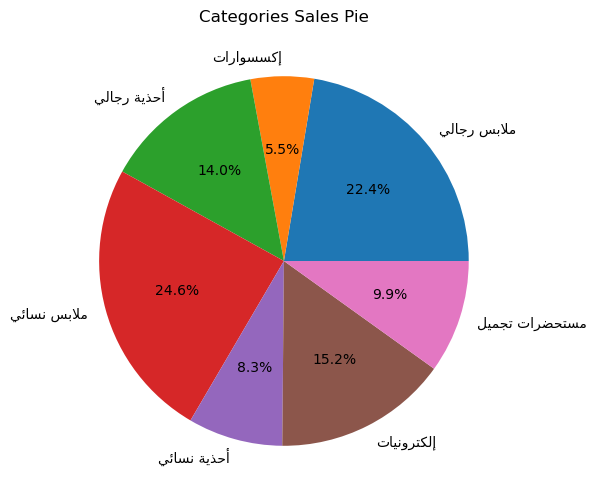

In [31]:
show_categories_sales_pie()